In [41]:
from pathlib import Path
from textwrap import wrap

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.feature_selection import f_regression, mutual_info_regression
from pandas.api.types import is_numeric_dtype, is_object_dtype
from matplotlib.gridspec import GridSpec


ON_KAGGLE = False
MODELS_PATH = Path("models")
MODELS_PATH.mkdir(exist_ok=True)  # If directory exists, do nothing.
DARK_BLUE = "#141b4d"

my_rc = {
    "axes.labelcolor": DARK_BLUE,
    "axes.labelsize": 14,
    "axes.labelpad": 20,
    "axes.labelweight": "bold",
    "axes.titlesize": 16,
    "axes.titleweight": "bold",
    "axes.titlepad": 20,
    "xtick.labelsize": 12,
    "xtick.color": DARK_BLUE,
    "ytick.labelsize": 12,
    "ytick.color": DARK_BLUE,
    "figure.titlesize": 16,
    "figure.titleweight": "bold",
    "font.size": 13,
    "font.weight": "bold",
    "text.color": DARK_BLUE,
}

sns.set_theme(rc=my_rc)


In [187]:
train_set = pd.read_csv("data/train.csv")
test_set = pd.read_csv("data/test.csv")

pd.options.display.max_columns = train_set.shape[1]


In [43]:
class CategoryFeatureHandler:
    """Provides a piece of information about the categorical feature
    in a more pleasant manner. See `create_categories_info()` and
    `categories_info_plot()` methods."""

    def __init__(self, dataset):
        """Initialize the handler by copying the original `dataset`."""
        self.df = dataset.copy()

    def create_categories_info(self, cat_feature, num_feature):
        """Creates a new Data Frame with `cat_feature` categories
        with respect to `num_feature`"""
        df = self.df

        if not is_object_dtype(df[cat_feature]):
            raise TypeError("The `cat_feature` is not a `object` dtype.")
        if not is_numeric_dtype(df[num_feature]):
            raise TypeError("The `num_feature` is not a `numeric` dtype.")

        df[cat_feature].fillna("Missing", inplace=True)

        info_df = (
            df.groupby(cat_feature)
            .agg(
                Median=(num_feature, np.nanmedian),
                Mean=(num_feature, np.nanmean),
                RelMeanDiff=(
                    num_feature,
                    lambda x: (np.nanmean(x) - np.nanmedian(x)) / np.nanmedian(x) * 100
                    if np.nanmedian(x) > 0
                    else 0,
                ),
            )
            .add_prefix(f"{num_feature} ")
        )

        # What percentile of the whole `num_feature` constitutes
        # the calculated median / mean for a given category?
        for measure in ("Median", "Mean"):
            non_nan_values = df.loc[~df[num_feature].isna(), num_feature]
            info_df[f"{num_feature} {measure}Pcnt"] = [
                stats.percentileofscore(non_nan_values, score)
                for score in info_df[f"{num_feature} {measure}"]
            ]

        info_df["Counts"] = df[cat_feature].value_counts()
        info_df["Counts Ratio"] = df[cat_feature].value_counts(normalize=True)
        self.info_df = info_df
        self._provide_consistent_cols_order()

        return self.info_df.copy()

    def _provide_consistent_cols_order(self):
        """Adds private attributes to pass column names easily. Changes the column order
        in the `info_df` to be more precise. This operation is not required but simplifies
        navigation in `_draw_descriptive_stats()`."""
        (
            self._median_name,
            self._mean_name,
            self._rel_mean_diff_name,
            self._median_pctl_name,
            self._mean_pctl_name,
            self._counts_name,
            self._counts_ratio_name,
        ) = self.info_df.columns

        self.info_df = self.info_df[
            [
                self._counts_name,
                self._counts_ratio_name,
                self._median_name,
                self._median_pctl_name,
                self._mean_name,
                self._mean_pctl_name,
                self._rel_mean_diff_name,
            ]
        ]

        self._n_categories_in = self.info_df.shape[0]
        self._n_stats_in = self.info_df.shape[1]
        self._stat_names_in = self.info_df.columns

    def categories_info_plot(self, cat_feature, num_feature, palette="flare_r"):
        """Creates a new figure with bar plots and descriptive statistics.
        The figure height is scalable with a large number of categories."""
        self.create_categories_info(cat_feature, num_feature)

        fig_height = 8
        if self._n_categories_in > 5:
            fig_height += (self._n_categories_in - 5) * 0.5

        fig = plt.figure(figsize=(14, fig_height), tight_layout=True)
        sns.set_palette(palette, self._n_categories_in)
        plt.suptitle(
            f"{cat_feature} vs {self._counts_name} & {self._median_name} & {self._rel_mean_diff_name}"
        )
        gs = GridSpec(nrows=2, ncols=3, figure=fig)

        ax1 = fig.add_subplot(gs[0, 0])  # Counts.
        ax2 = fig.add_subplot(gs[0, 1])  # Median.
        ax3 = fig.add_subplot(gs[0, 2])  # Relative Mean Diff.
        ax4 = fig.add_subplot(gs[1, :])  # Descriptive Stats.

        for ax, stat_name in zip(
            (ax1, ax2, ax3),
            (self._counts_name, self._median_name, self._rel_mean_diff_name),
        ):
            self._plot_category_vs_stat_name(ax, stat_name)
            if not ax == ax1:
                plt.ylabel("")

        self._draw_descriptive_stats(ax4)
        sns.set_palette("deep")  # Default palette.

    def _plot_category_vs_stat_name(self, ax, stat_name):
        """Plots a simple barplot (`category` vs `stat_name`) in the current axis."""
        info_df = self.info_df
        order = info_df.sort_values(stat_name, ascending=False).index
        plt.sca(ax)
        plt.yticks(rotation=30)
        sns.barplot(data=info_df, x=stat_name, y=info_df.index, order=order)

    def _draw_descriptive_stats(self, ax4):
        """Draws info from the `info_df` at the bottom of the figure."""
        plt.sca(ax4)
        plt.ylabel("Descriptive Statistics")
        plt.xticks([])
        plt.yticks([])

        xspace = 1 / (self._n_stats_in + 1)  # +1 due to one for a category.
        yspace = 1 / (self._n_categories_in + 1 + 1)  # +2 due to wide header.

        xpos = xspace / 2
        ypos = 1 - yspace
        wrapper = lambda text, width: "\n".join(line for line in wrap(text, width))

        for header in np.r_[["Category"], self._stat_names_in]:
            header = wrapper(header, 15)
            plt.text(xpos, ypos, header, ha="center", va="center", fontsize=14)
            xpos += xspace

        """Provide formatting for the plot. The `itertuples()` method iterates over 
        DataFrame rows as named tuples, so each row (tuple) contains one element from 
        each column. We can unpack this tuple in the `format()` method using *args syntax. 
        Therefore each component will be formatted with the defined pattern. Nevertheless,
        values compose one string. Thus we use the `split()` method later. This way, we can 
        easily plot info from the data frame using a fancy format. The only drawback is that 
        you must know the order of the columns."""

        pattern = "{};{};{:.2%};{:,.1f};{:.0f};{:,.1f};{:.0f};{:+.2f}"
        category_stats = [pattern.format(*row) for row in self.info_df.itertuples()]

        for i, cat_stats in enumerate(category_stats):
            ypos = 1 - (5 / 2 + i) * yspace
            plt.axhline(ypos + yspace / 2, color="white", linewidth=5)
            for j, cat_stat in enumerate(cat_stats.split(";")):
                xpos = (1 / 2 + j) * xspace
                plt.text(xpos, ypos, cat_stat, ha="center", va="center")


In [44]:
# cfh = CategoryFeatureHandler(train_set)
# cfh.categories_info_plot("LotShape", "SalePrice", palette="mako_r")


###

### **SITUATION**

- `LotShape` - _General shape of property._  
  A more interesting feature with four categories. It's reasonable to join the `IR1`, `IR2`, and `IR3` categories into one. Houses with these categories have similar median and mean prices. Thus we'll obtain two categories, `IR` (irregular) and `Reg` (regular), so the OneHotEncoder should be fine. Curiously houses with irregular shapes of property have higher prices.
- `LotConfig` - _Lot configuration._  
  The `FR3` category has only four counts. We can probably merge it with `FR2`. OneHotEncoder is appropriate, I think.
- `LandContour` - _Flatness of the property._  
  Large imbalance in favour of `Lvl` (Near Flat/Level). It has around 90% of the counts. It's difficult to say something, but there is a significant gap between prices for `HLS` and `Low` vs `Bnk`. It's something which resembles grading, so the OrdinalEncoder should probably be used.
- `MSZoning` - _Identifies the general zoning classification of the sale._  
  Here, we have five imbalanced categories. The `RL` (_Residential Low Density_) category account for almost 79% of the entire feature. Moreover, the mean `SalePrice` for this category is around 10% higher than the median, so we have a slight asymmetry here. The median `SalePrice` is 174000, constituting the 56th percentile of all prices. The second most frequent category is `RM` (_Residential Medium Density_), about 15% of total counts. Prices are much lower here; the median price is 120500, the 19th percentile of all prices. The highest prices are for `FV` (_Floating Village Residential_) (65 counts - 4.5%). Here we have prices where the median is 205950 and the mean is 214014, which constitutes the 73rd and 75th percentile, respectively. Perhaps we should encode this feature with OneHotEncoder, but the `Residential` categories are graded, so maybe OrdinalEncoder? 
- `Neighborhood` - _Physical locations within Ames city limits._  
  Here we have a lot of categories. It's probably something like districts. In my opinion, we may join these categories in regards to `SalePrice` median in these districts and create buckets. For example, in the "VeryRich" bucket, we put these categories where the `SalePrice` median is above 250000. In the "Rich," we put these with 200000 - 250000, and so on. 
- `Condition1` - _Proximity to various conditions._  
  Imbalance in favour of the `Norm` category (around 86%). Here are several categories that can possibly be merged (based on their descriptions). For example, `PosA` with `PosN`, `RRAe` with `RRAn`, and `RRNe` with `RRNn`. Then we use OneHotEncoder.

### **HOUSE STYLE**

- `BldgType` - _Type of dwelling_.  
  Here are two similar categories, i.e. `Twnhs` and `TwnhsE`, that have the potential to merge, but the median and mean sale prices for them have a significant difference. Moreover, `TwnhsE` has regular distribution, meanwhile `Twnhs` has not. Probably we should leave it as it is. This feature represents different types of buildings, so the OneHotEncoder is a good choice.
- `HouseStyle` - _Style of dwelling._  
  Here it's possible we can merge `1Story` with `1.5Fin` and `1.5Unf`. Similarly, with `2Story`, `2.5Fin` and `2.5Unf`. Remain two categories, i.e. `SFoyer` and `SLvl`. It's a split style, so that we could merge them too. Then encode these categories with OneHotEncoder. 
- `RoofStyle` - _Type of roof._ Perhaps 
- `Exterior1st` - _Exterior covering on house._ 
- `Exterior2nd` - _Exterior covering on house (if more than one material)._ 
- `MasVnrType` - _Masonry veneer type._   
  There are 8 missing values. It's reasonable to fill them with most frequent strategy We can join `BrkCmn` with `BrkFace`. Then use OneHotEncoder.
- `ExterQual` - _Evaluates the quality of the material on the exterior._  
  It's ordinary grading (Excellent, Good, Average,...). We will just use OrdinalEncoder.
- `ExterCond` - _Evaluates the present condition of the material on the exterior._  
  Similarly as for `ExterQual` - OrdinalEncoder.
- `Foundation` - _Type of foundation._  
  It represents different types of foundations. I don't know what to do with this, so we will just encode it with OneHotEncoder.
- `PavedDrive` - _Paved driveway_. Here we have `Y` (Paved), `P` (Partial Pavement) and `N` (Dirt/Gravel), so probably OrdinalEncoder will be fine.

### **HOUSE ELEMENTS**

- `HeatingQC` - _Heating quality and condition._  
  It's ordinary grading (Excellent, Good, Average,...). It's nothing to do here, just OrdinalEncoder.
- `CentralAir` - _Central air conditioning._  
  Whether the house has air conditioning or not. Here is an imbalance for `Y` (93%), but probably it's better to leave this feature. Houses without air conditioning have lower prices.
- `Electrical` - _Electrical system._  
  Again we have an imbalance here. Over 91% of counts constitute the `SBrkr` category. Reading the description, I think we may merge `FuseA`, `FuseF`, `FuseF` and `Mix` into one category and encode that feature with OneHotEncoder.
- `KitchenQual` - _Kitchen quality._  
  It's ordinary grading (Excellent, Good, Average,...), so the OrdinalEncoder will be fine.
- `FireplaceQu` - _Fireplace quality_.
  Simple grading, but we have around 47% of missing values here. 
- `LandSlope` - _Slope of property._  
  Here we have three graded categories but with large imbalance in favour of `Gtl` (around 95% of counts). I think we should drop this, but when we leave it, then the OrdinalEncoder should be used.

### **BASEMENT**

- `BsmtQual` - 
- `BsmtCond` - 
- `BsmtExposure` - 
- `BsmtFinType1` - 
- `BsmtFinType2` - 

### **GARAGE**

- `GarageType` - 
- `GarageFinish` - 
- `GarageQual` - 
- `GarageCond` - 

### **OTHER**

- `SaleType` - _Type of sale._  
  From the description, we may join warranty categories, i.e. `WD`, `CWD`, `VWD`, contract categories, i.e. `Con`, `ConLw`, `ConLI`, `ConLD` and `COD`, `Oth`. We should leave the `New` category for sure. It has not bad number of counts (around 8%), and it's easy to observe these houses are expensive.
- `SaleCondition` - _Condition of sale._  
  Probably we should leave it as it is and use OneHotEncoder.

### **TO DROP PROBABLY**

- `Street` - _Type of road access to property._ Huge imbalance. The `Pave` category constitutes about 99.6%. We'll drop this feature.
- `Alley` - _Type of alley access to property._ Here is a similar situation but on the other way. We have 94% missing values. We'll drop this feature.
- `Utilities` - _Type of utilities available._ There are two categories and the second one has only one count, so the feature should be dropped for sure.
- `Condition2` - _Proximity to various conditions (if more than one is present)._ Huge imbalance (99% of all counts) for only one category. We'll drop this.
- `Heating` - _Type of heating._ Huge imbalance (98%) for `GasA`. We'll drop this feature.
- `PoolQC` - _Pool quality_. There is too significant imbalance (99.5%) of missing values. At this moment we should drop this.
- `Fence` - _Fence quality_. There we have around 81% of missing values. We should probably drop this. In the dataset, there is no other feature related to Fence.
- `MiscFeature` - _Miscellaneous feature not covered in other categories_. Again too many missing values (96%). We should drop this at this moment.
- `Functional` - _Home functionality (Assume typical unless deductions are warranted)_. Probably this feature should be dropped.
- `RoofMatl` - _Roof material_.  
  A Huge imbalance (98%) in favour of one category, `CompShg`. We should drop this feature.

## **CUSTOM TRANSFORMERS:**

In [138]:
from sklearn.base import (
    BaseEstimator,
    TransformerMixin,
    clone,
    check_is_fitted,
)
from sklearn.preprocessing import (
    OrdinalEncoder,
    OneHotEncoder,
    FunctionTransformer,
    MinMaxScaler,
)
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import RidgeCV


In [132]:
class CustomImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.copy()

        garage_mask = np.isclose(X["GarageArea"], 0)
        garage_cats = ["GarageType", "GarageFinish", "GarageQual", "GarageCond"]
        garage_nums = ["GarageCars", "GarageYrBlt"]
        X.loc[garage_mask, garage_cats] = "NA"
        X.loc[garage_mask, garage_nums] = 0

        bsmt_mask = np.isclose(X["TotalBsmtSF"], 0)
        bsmt_cats = [
            "BsmtQual",
            "BsmtCond",
            "BsmtExposure",
            "BsmtFinType1",
            "BsmtFinType2",
        ]
        bsmt_nums = ["BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF"]
        X.loc[bsmt_mask, bsmt_cats] = "NA"
        X.loc[bsmt_mask, bsmt_nums] = 0

        X.loc[np.isclose(X["Fireplaces"], 0), "FireplaceQu"] = "NA"

        return X


In [135]:
class NeighborhoodTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        self.districts_affluence_ = pd.cut(
            X[["Neighborhood", "SalePrice"]]
            .groupby("Neighborhood")
            .median()["SalePrice"],
            bins=5,
            labels=["Poor", "BelowAverage", "Average", "AboveAverage", "Rich"],
        ).cat.codes
        return self

    def transform(self, X, y=None):
        X = X.copy()
        X["Neighborhood"] = X["Neighborhood"].map(self.districts_affluence_)
        return X

In [133]:
class CustomCategoryTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        if not isinstance(X, pd.DataFrame):
            raise TypeError("X must be a pandas DataFrame.")

        self.n_features_in_ = X.shape[1]
        self.feature_names_in_ = np.array(X.columns, dtype=object)

        return self

    def transform(self, X, y=None):
        if not isinstance(X, pd.DataFrame):
            raise TypeError("X must be a pandas DataFrame.")
        if self.n_features_in_ != X.shape[1]:
            raise ValueError("Unexpected number of features.")
        X = X.copy()

        self._transform_lot_shape(X)
        self._transform_lot_config(X)
        self._transform_mas_vnr_type(X)
        self._transform_bldg_type(X)
        self._transform_house_style(X)
        self._transform_condition1(X)
        self._transform_sale_type(X)
        self._transform_electrical(X)

        return X

    def _transform_lot_shape(self, X):
        lot_shape_mask = X["LotShape"].isin(("IR1", "IR2", "IR3"))
        X.loc[lot_shape_mask, "LotShape"] = "IR"

    def _transform_lot_config(self, X):
        lot_config_mask = X["LotConfig"].isin(("FR2", "FR3"))
        X.loc[lot_config_mask, "LotConfig"] = "FR"

    def _transform_mas_vnr_type(self, X):
        brk_mask = X["MasVnrType"].isin(("BrkFace", "BrkCmn"))
        X.loc[brk_mask, "MasVnrType"] = "Brick"

    def _transform_bldg_type(self, X):
        twnhs_mask = X["BldgType"].isin(("TwnhsE", "Twnhs"))
        X.loc[twnhs_mask, "BldgType"] = "Twnhs"

    def _transform_house_style(self, X):
        story1_mask = X["HouseStyle"].isin(("1Story", "1.5Fin", "1.5Unf"))
        story2_mask = X["HouseStyle"].isin(("2Story", "2.5Fin", "2.5Unf"))
        X.loc[story1_mask, "HouseStyle"] = "1Story"
        X.loc[story2_mask, "HouseStyle"] = "2Story"

    def _transform_condition1(self, X):
        rra_mask = X["Condition1"].isin(("RRAe", "RRAn"))
        rrn_mask = X["Condition1"].isin(("RRNn", "RRNe"))
        pos_mask = X["Condition1"].isin(("PosN", "PosA"))

        X.loc[rra_mask, "Condition1"] = "RRA"
        X.loc[rrn_mask, "Condition1"] = "RRN"
        X.loc[pos_mask, "Condition1"] = "Pos"

    def _transform_sale_type(self, X):
        warranty_mask = X["SaleType"].isin(("WD", "CWD", "VWD"))
        contract_mask = X["SaleType"].isin(("Con", "ConLw", "ConLI", "ConLD"))
        other_mask = ~(warranty_mask | contract_mask)
        X.loc[warranty_mask, "SaleType"] = "Warranty"
        X.loc[contract_mask, "SaleType"] = "Contract"
        X.loc[other_mask, "SaleType"] = "Other"

    def _transform_electrical(self, X):
        electr_mask = X["Electrical"] != "SBrkr"
        X.loc[electr_mask, "Electrical"] = "Fuse"


In [136]:
class LotFrontageImputer(BaseEstimator, TransformerMixin):
    def __init__(self, estimator=RidgeCV()):
        self.estimator = estimator

    def fit(self, X, y=None):
        train_mask = ~X["LotFrontage"].isna()
        X_train = X.loc[train_mask, "LotArea"]
        y_train = X.loc[train_mask, "LotFrontage"]

        X_prepared = np.log1p(X_train.values.reshape(-1, 1))
        y_prepared = np.log1p(y_train.values)

        estimator_ = clone(self.estimator)
        estimator_.fit(X_prepared, y_prepared)  # type: ignore

        self.estimator_ = estimator_
        self.n_features_in_ = self.estimator_.n_features_in_  # type: ignore

        if hasattr(self.estimator, "feature_names_in"):
            self.feature_names_in_ = self.estimator.feature_names_in_

        return self

    def transform(self, X, y=None):
        check_is_fitted(self)

        predict_mask = X["LotFrontage"].isna()
        if predict_mask.sum() == 0:
            return X

        X = X.copy()
        X_to_predict = X.loc[predict_mask, "LotArea"]
        X_prepared = np.log1p(X_to_predict.values.reshape(-1, 1))

        predictions = self.estimator_.predict(X_prepared)  # type: ignore
        X.loc[predict_mask, "LotFrontage"] = np.expm1(predictions)

        return X


In [48]:
train_set = pd.read_csv("data/train.csv")
test_set = pd.read_csv("data/test.csv")

train_cats = train_set.select_dtypes(include="object")
train_nums = train_set.select_dtypes(include="number")
train_cats_missing = train_cats.isna().sum()[train_cats.isna().sum() > 0]
train_nums_missing = train_nums.isna().sum()[train_nums.isna().sum() > 0]

test_cats = test_set.select_dtypes(include="object")
test_nums = test_set.select_dtypes(include="number")
test_cats_missing = test_cats.isna().sum()[test_cats.isna().sum() > 0]
test_nums_missing = test_nums.isna().sum()[test_nums.isna().sum() > 0]

In [50]:
from scipy.stats import pearsonr   

has_lot_frontage = ~train_set["LotFrontage"].isna()
lot_area = train_set.loc[has_lot_frontage, "LotArea"] 
lot_frontage = train_set.loc[has_lot_frontage, "LotFrontage"] 
lot_frontage_to_predict = train_set.loc[~has_lot_frontage, "LotArea"]

corr, pvalue = pearsonr(np.log(lot_area), np.log(lot_frontage))
corr

0.745550090492558

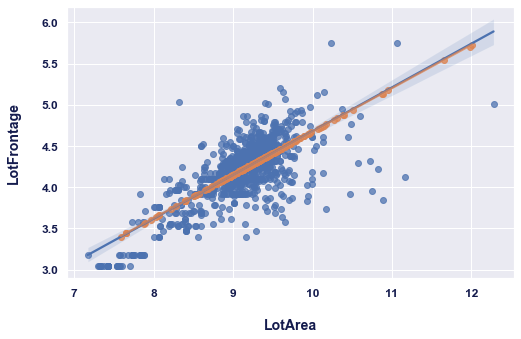

In [52]:
lfi = LotFrontageImputer()
res_train = lfi.fit_transform(train_set)
res_test = lfi.transform(test_set)

nan_mask = train_set["LotFrontage"].isna()

x_initial = np.log(train_set["LotArea"])
y_initial = np.log(train_set["LotFrontage"])

x_predicted = np.log(res_train.loc[nan_mask, "LotArea"])
y_predicted = np.log(res_train.loc[nan_mask, "LotFrontage"])

plt.figure(figsize=(8, 5))
sns.regplot(x=x_initial, y=y_initial, scatter_kws={"alpha": 0.75})
sns.regplot(x=x_predicted, y=y_predicted, line_kws={"alpha": 0.75})
plt.show()

In [53]:
x_initial = np.log(train_set.loc[~nan_mask, "LotArea"])
y_initial = np.log(train_set.loc[~nan_mask, "LotFrontage"])

fstat, pvalue = f_regression(x_initial.values.reshape(-1, 1), y_initial)
fstat / np.max(fstat)

mi = mutual_info_regression(x_initial.values.reshape(-1, 1), y_initial)
mi / np.max(mi)

array([1.])

In [189]:
hot_encoder = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="infrequent_if_exist"),
)

ord_encoder = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1),
)

log1p_transformer = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log1p, np.expm1),
)

identity_transformer = make_pipeline(
    # SimpleImputer(strategy="median"),
    FunctionTransformer(),
)

preprocessing = make_column_transformer(
    (
        hot_encoder,
        [
            "LotShape",
            "LotConfig",
            "MSZoning",
            "Condition1",
            "BldgType",
            "HouseStyle",
            "RoofStyle",
            "Exterior1st",
            "Exterior2nd",
            "MasVnrType",
            "Foundation",
            "CentralAir",
            "Electrical",
            "GarageType",
            "SaleType",
            "SaleCondition",
        ],
    ),
    (
        ord_encoder,
        [
            # "Neighborhood",
            "LandContour",
            "ExterQual",
            "ExterCond",
            "HeatingQC",
            "KitchenQual",
            "FireplaceQu",
            "LandSlope",
            "BsmtQual",
            "BsmtCond",
            "BsmtExposure",
            "BsmtFinType1",
            "BsmtFinType2",
            "GarageFinish",
            "GarageQual",
            "GarageCond",
            "PavedDrive",
        ],
    ),
    (
        log1p_transformer,
        [
            "LotFrontage",
            "LotArea",
            "GrLivArea",
        ],
    ),
    (
        identity_transformer,
        [
            "Neighborhood",
        ],
    ),
    remainder="drop",
)


In [194]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import RandomizedSearchCV
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import HuberRegressor, LinearRegression, Ridge, RidgeCV, Lasso
from sklearn.svm import LinearSVR
from scipy.stats import randint, uniform

custom_pipeline = make_pipeline(
    CustomImputer(),
    LotFrontageImputer(),
    NeighborhoodTransformer(),
)

train_labels = train_set["SalePrice"]
train_default = train_set.drop("SalePrice", axis=1)

train_transformed = custom_pipeline.fit_transform(train_set)
train_transformed = train_transformed.drop("SalePrice", axis=1)

full_pipeline = make_pipeline(
    preprocessing,
    # SelectFromModel(GradientBoostingRegressor(), threshold=1e-4),
    TransformedTargetRegressor(
        RidgeCV(),
        func=np.log,
        inverse_func=np.exp,
    ),
)

rmses = -cross_val_score(
    full_pipeline,
    train_transformed,
    train_labels,
    cv=5,
    scoring="neg_root_mean_squared_error",
    error_score="raise",  # type: ignore
)
pd.Series(rmses).describe()

count        5.000000
mean     31610.598002
std       6025.222532
min      25736.585573
25%      26550.944833
50%      32420.595428
75%      32597.589173
max      40747.275005
dtype: float64

In [193]:
test_transformed = custom_pipeline.transform(test_set)
full_pipeline.fit(train_transformed, train_labels)
full_pipeline.predict(test_transformed)

array([107119.83005957, 171581.53569578, 192009.16974775, ...,
       141515.79311658, 126550.17971028, 201347.90279996])